In [1]:
from lightgbm import LGBMRegressor

import optuna
from optuna.visualization.matplotlib import plot_param_importances
from optuna.visualization import plot_optimization_history

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_squared_log_error

from catboost import CatBoostRegressor
import shap

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression

import warnings

warnings.filterwarnings("ignore")

RAND = 19
N_FOLDS = 3

# Utility function

In [2]:
def r2_adjusted(y_true: np.ndarray, y_pred: np.ndarray,
                X_test: np.ndarray) -> float:
    """Коэффициент детерминации (множественная регрессия)"""
    N_objects = len(y_true)
    N_features = X_test.shape[1]
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (N_objects - 1) / (N_objects - N_features - 1)


def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean percentage error"""
    return np.mean((y_true - y_pred) / y_true) * 100


def mape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Mean absolute percentage error"""
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100


def wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Weighted Absolute Percent Error"""
    return np.sum(np.abs(y_pred - y_true)) / np.sum(y_true) * 100


def rmsle(y_true: np.ndarray, y_pred: np.ndarray) -> np.float64:
    """
    The Root Mean Squared Log Error (RMSLE) metric 
    Логаритмическая ошибка средней квадратичной ошибки
    """
    try:
        return np.sqrt(mean_squared_log_error(y_true, y_pred))
    except:
        return None


def get_metrics(y_test: np.ndarray,
                y_pred: np.ndarray,
                X_test: np.ndarray,
                name: str = None):
    """Генерация таблицы с метриками"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]

    df_metrics['MAE'] = mean_absolute_error(y_test, y_pred)
    df_metrics['MSE'] = mean_squared_error(y_test, y_pred)
    df_metrics['RMSE'] = np.sqrt(mean_squared_error(y_test, y_pred))
    df_metrics['RMSLE'] = rmsle(y_test, y_pred)
    df_metrics['R2 adjusted'] = r2_adjusted(y_test, y_pred, X_test)
    df_metrics['MPE_%'] = mpe(y_test, y_pred)
    df_metrics['MAPE_%'] = mape(y_test, y_pred)
    df_metrics['WAPE_%'] = wape(y_test, y_pred)

    return df_metrics


def check_overfitting(model, X_train, y_train, X_test, y_test, metric_fun):
    """
    Проверка на overfitting
    """
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    mae_train = metric_fun(y_train, y_pred_train)
    mae_test = metric_fun(y_test, y_pred_test)

    print(f'{metric_fun.__name__} train: %.3f' % mae_train)
    print(f'{metric_fun.__name__} test: %.3f' % mae_test)
    print(f'delta = {(abs(mae_train - mae_test)/mae_train*100):.1f} %')

# Load data

Берем только БУ авто

In [3]:
df = pd.read_csv('data/clean_full_dataset.csv')
df = df[df.flg_new_auto == 0]

In [4]:
df.shape

(24926, 19)

Желательно напарсить больше данных, примерно 50 тыс.

In [5]:
df.head()

,num,brand,model,year,price,region,median_salary,Region_en,NAME_1,flg_more_avg_salary,age,liters,horse_power,type_engine,transmission,machine_drive,mileage,flg_new_auto,body_type
0,1,Mercedes-Benz,E-Class,2006,830000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,17,3.2,204.0,дизель,автомат,задний,350.0,0,Седан
1,1,Mercedes-Benz,E-Class,1999,280000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,24,2.8,193.0,бензин,автомат,задний,360.0,0,Седан
2,1,Mercedes-Benz,E-Class,1991,200000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,32,3.0,220.0,бензин,автомат,задний,352.0,0,Седан
3,1,Mercedes-Benz,C-Class,2011,900000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,12,1.8,156.0,бензин,автомат,задний,134.0,0,Седан
4,1,Mercedes-Benz,A-Class,2000,250000,Республика Адыгея,38435.1,Republic of Adygea,Adygey,0,23,1.6,102.0,бензин,механика,передний,228.0,0,Хэтчбэк


### Удаляем ненужные столбцы

In [6]:
cols_drop = [
    'brand', 'num', 'year', 'median_salary', 'Region_en', 'NAME_1',
    'flg_more_avg_salary', 'flg_new_auto'
]
df = df.drop(cols_drop, axis=1)


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24926 entries, 0 to 26067
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   model          24926 non-null  object 
 1   price          24926 non-null  int64  
 2   region         24926 non-null  object 
 3   age            24926 non-null  int64  
 4   liters         24926 non-null  float64
 5   horse_power    24926 non-null  float64
 6   type_engine    24926 non-null  object 
 7   transmission   24926 non-null  object 
 8   machine_drive  24926 non-null  object 
 9   mileage        24926 non-null  float64
 10  body_type      24926 non-null  object 
dtypes: float64(3), int64(2), object(6)
memory usage: 2.3+ MB


In [8]:
cols_cat = df.select_dtypes('object').columns
df[cols_cat] = df[cols_cat].astype('category')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24926 entries, 0 to 26067
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   model          24926 non-null  category
 1   price          24926 non-null  int64   
 2   region         24926 non-null  category
 3   age            24926 non-null  int64   
 4   liters         24926 non-null  float64 
 5   horse_power    24926 non-null  float64 
 6   type_engine    24926 non-null  category
 7   transmission   24926 non-null  category
 8   machine_drive  24926 non-null  category
 9   mileage        24926 non-null  float64 
 10  body_type      24926 non-null  category
dtypes: category(6), float64(3), int64(2)
memory usage: 1.3 MB


In [10]:
df[:4]

,model,price,region,age,liters,horse_power,type_engine,transmission,machine_drive,mileage,body_type
0,E-Class,830000,Республика Адыгея,17,3.2,204.0,дизель,автомат,задний,350.0,Седан
1,E-Class,280000,Республика Адыгея,24,2.8,193.0,бензин,автомат,задний,360.0,Седан
2,E-Class,200000,Республика Адыгея,32,3.0,220.0,бензин,автомат,задний,352.0,Седан
3,C-Class,900000,Республика Адыгея,12,1.8,156.0,бензин,автомат,задний,134.0,Седан


# Modeling

In [11]:
X = df.drop(['price'], axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    shuffle=True,
                                                    random_state=RAND)

X_train_, X_val, y_train_, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.16,
                                                    random_state=RAND)

eval_set = [(X_val, y_val)]

### Create transformer data

In [14]:
from sklearn.compose import ColumnTransformer


transformers_list = [
    ('encode', OneHotEncoder(dtype='int', drop='first'), [
        'region', 'model', 'region', 'type_engine', 'transmission',
        'machine_drive', 'body_type'
    ]),
    ('scale', StandardScaler(),
     ['age', 'liters', 'horse_power', 'mileage'])
]

column_transformer = ColumnTransformer(transformers_list)

## Baseline

### Linear Regrission

In [15]:
pipe = Pipeline([('columnTransformer', column_transformer),
                 ('lr', LinearRegression())])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

In [16]:
metrics = get_metrics(y_test, y_pred, X_test, 'LinearRegression_baseline')
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,801127.598375,2.130406e+12,1.459591e+06,None,0.707224,13.817645,74.367302,34.711321


In [17]:
check_overfitting(pipe,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 794504.296
mean_absolute_error test: 801127.598
delta = 0.8 %


> Модель ошибается на 800 тыс. рублей, очень много

### LGBMRegressor

In [18]:
lgb = LGBMRegressor(random_state=RAND, objective='mae')
lgb.fit(X_train_,
        y_train_,
        eval_metric="mae",
        eval_set=eval_set,
        verbose=False,
        early_stopping_rounds=100)

y_pred = lgb.predict(X_test)

In [19]:
metrics = metrics.append(
    get_metrics(y_test, y_pred, X_test, 'LGBMRegressor_baseline'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,801127.598375,2.130406e+12,1.459591e+06,NaN,0.707224,13.817645,74.367302,34.711321
0,LGBMRegressor_baseline,282734.086377,5.541899e+11,7.444393e+05,0.252406,0.923839,-4.294938,17.237760,12.250325


In [20]:
check_overfitting(lgb,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 261715.397
mean_absolute_error test: 282734.086
delta = 8.0 %


> Ошибка на 280 тыс, много. Наблюдаем небольшое переобучение

### CatBoostRegressor

In [21]:
cat_features = X_val.select_dtypes('category').columns.tolist()

cb = CatBoostRegressor(random_seed=RAND,
                       loss_function='MAE',
                       eval_metric='MAE',
                       cat_features=cat_features,
                       allow_writing_files=False)

eval_set = [(X_val, y_val)]

cb.fit(X_train_,
       y_train_,
       eval_set=eval_set,
       verbose=0,
       early_stopping_rounds=100)

y_pred_cb = cb.predict(X_test)

In [22]:
metrics = metrics.append(
    get_metrics(y_test, y_pred_cb, X_test, 'CatBoostRegressor_baseline'))
metrics

,model,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
0,LinearRegression_baseline,801127.598375,2.130406e+12,1.459591e+06,NaN,0.707224,13.817645,74.367302,34.711321
0,LGBMRegressor_baseline,282734.086377,5.541899e+11,7.444393e+05,0.252406,0.923839,-4.294938,17.237760,12.250325
0,CatBoostRegressor_baseline,303735.400932,6.035092e+11,7.768586e+05,0.256708,0.917061,-4.096321,17.676958,13.160272


In [23]:
check_overfitting(cb,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 282177.542
mean_absolute_error test: 303735.401
delta = 7.6 %


> Схожие показатели с LGBMRegressor

In [24]:
metrics.set_index('model').round(3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LinearRegression_baseline,801127.598,2.130406e+12,1459591.151,NaN,0.707,13.818,74.367,34.711
LGBMRegressor_baseline,282734.086,5.541899e+11,744439.297,0.252,0.924,-4.295,17.238,12.250
CatBoostRegressor_baseline,303735.401,6.035092e+11,776858.571,0.257,0.917,-4.096,17.677,13.160


## Tuning model

### LGBMRegressor

In [25]:
# целевая функция
def objective_lgb(trial, X, y, N_FOLDS, random_state):
    lgb_params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        # num_leaves - кол-во листьев для принятия решений в одном дереве
        "num_leaves": trial.suggest_int("num_leaves", 20, 150, step=1),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        # min_data_in_leaf - минимальное количество объектов, которые должны 
        # попасть в узел для его добавления
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 1000),
        "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-3, 100),
        "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-3, 100),
        "min_gain_to_split": trial.suggest_int("min_gain_to_split", 0, 15),
        # feature_fraction - процент признаков для выборки при обучении каждого дерева 
        "feature_fraction": trial.suggest_float("feature_fraction", 0.7, 1.0),  
        "objective": trial.suggest_categorical("objective", ['mae']),
        "random_state": trial.suggest_categorical("random_state", [random_state]),        
    }

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        model = LGBMRegressor(**lgb_params)
        model.fit(X_train,
                  y_train,
                  eval_set=[(X_test, y_test)],
                  eval_metric="mae",
                  early_stopping_rounds=100,
                  verbose=0)
        
        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [26]:
study = optuna.create_study(direction="minimize", study_name="LGB_21")


def func(trial):
    return objective_lgb(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND)

optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(func, n_trials=15, show_progress_bar=True)

[I 2023-04-04 19:13:08,084] A new study created in memory with name: LGB_21


  0%|          | 0/15 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.8540256672337673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8540256672337673
[LightGBM] [Warning] min_data_in_leaf is set=646, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=646
[LightGBM] [Warning] min_gain_to_split is set=1, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1
[LightGBM] [Warning] lambda_l1 is set=0.0019359861075255499, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019359861075255499
[LightGBM] [Warning] lambda_l2 is set=0.4068703417493615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.4068703417493615
[LightGBM] [Warning] feature_fraction is set=0.8540256672337673, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8540256672337673
[LightGBM] [Warning] min_data_in_leaf is set=646, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=646
[LightGBM] [Warning] min_gain_to_split is set=1, mi

[LightGBM] [Warning] feature_fraction is set=0.7322778864172516, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7322778864172516
[LightGBM] [Warning] min_data_in_leaf is set=953, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=953
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l1 is set=0.009842206905892555, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009842206905892555
[LightGBM] [Warning] lambda_l2 is set=0.2125347112453024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2125347112453024
[LightGBM] [Warning] feature_fraction is set=0.7842880336397575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7842880336397575
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=12, m

[LightGBM] [Warning] feature_fraction is set=0.8457039791276721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8457039791276721
[LightGBM] [Warning] min_data_in_leaf is set=958, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=958
[LightGBM] [Warning] min_gain_to_split is set=11, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=11
[LightGBM] [Warning] lambda_l1 is set=0.0027717245790851684, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0027717245790851684
[LightGBM] [Warning] lambda_l2 is set=0.9505473495069531, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9505473495069531
[LightGBM] [Warning] feature_fraction is set=0.8457039791276721, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8457039791276721
[LightGBM] [Warning] min_data_in_leaf is set=958, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=958
[LightGBM] [Warning] min_gain_to_split is set=11,

[LightGBM] [Warning] feature_fraction is set=0.7070317737231705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7070317737231705
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=13
[LightGBM] [Warning] lambda_l1 is set=2.5318832641726834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5318832641726834
[LightGBM] [Warning] lambda_l2 is set=0.021955613863530427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021955613863530427
[LightGBM] [Warning] feature_fraction is set=0.7070317737231705, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7070317737231705
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_gain_to_split is set=13, m

In [27]:
study.best_params

{'n_estimators': 300,
 'learning_rate': 0.14115528785116307,
 'num_leaves': 57,
 'max_depth': 6,
 'min_data_in_leaf': 100,
 'lambda_l1': 2.878930934672144,
 'lambda_l2': 0.056663439320527476,
 'min_gain_to_split': 12,
 'feature_fraction': 0.7842880336397575,
 'objective': 'mae',
 'random_state': 19}

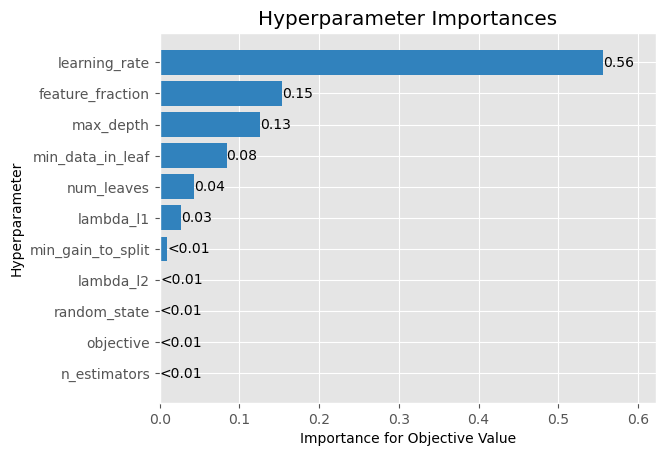

In [29]:
plot_param_importances(study);

In [30]:
best_params_ver1 = study.best_params
lgb_optuna = LGBMRegressor(**best_params_ver1)
lgb_optuna.fit(X_train_,
               y_train_,
               eval_metric="mae",
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

y_pred = lgb_optuna.predict(X_test)

metrics = metrics.append(
    get_metrics(y_test=y_test,
                y_pred=y_pred,
                X_test=X_test,
                name='LGBoost_Optuna'))

round(metrics.set_index('model'), 3)

[LightGBM] [Warning] feature_fraction is set=0.7842880336397575, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7842880336397575
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l1 is set=2.878930934672144, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.878930934672144
[LightGBM] [Warning] lambda_l2 is set=0.056663439320527476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056663439320527476


,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LinearRegression_baseline,801127.598,2.130406e+12,1459591.151,NaN,0.707,13.818,74.367,34.711
LGBMRegressor_baseline,282734.086,5.541899e+11,744439.297,0.252,0.924,-4.295,17.238,12.250
CatBoostRegressor_baseline,303735.401,6.035092e+11,776858.571,0.257,0.917,-4.096,17.677,13.160
LGBoost_Optuna,326050.150,8.329621e+11,912667.557,0.272,0.886,-5.380,19.395,14.127


In [31]:
check_overfitting(lgb_optuna,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 315607.838
mean_absolute_error test: 326050.150
delta = 3.3 %


In [32]:
study.optimize(func, n_trials=25, show_progress_bar=True)

  0%|          | 0/25 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.7586854749813443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7586854749813443
[LightGBM] [Warning] min_data_in_leaf is set=239, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=239
[LightGBM] [Warning] min_gain_to_split is set=12, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12
[LightGBM] [Warning] lambda_l1 is set=3.548954982747026, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.548954982747026
[LightGBM] [Warning] lambda_l2 is set=0.06992908513860337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06992908513860337
[LightGBM] [Warning] feature_fraction is set=0.7586854749813443, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7586854749813443
[LightGBM] [Warning] min_data_in_leaf is set=239, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=239
[LightGBM] [Warning] min_gain_to_split is set=12, min_s

[LightGBM] [Warning] feature_fraction is set=0.8044567384518392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044567384518392
[LightGBM] [Warning] min_data_in_leaf is set=772, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=772
[LightGBM] [Warning] min_gain_to_split is set=10, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=10
[LightGBM] [Warning] lambda_l1 is set=8.839870553092108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.839870553092108
[LightGBM] [Warning] lambda_l2 is set=0.006426116537765945, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006426116537765945
[LightGBM] [Warning] feature_fraction is set=0.8044567384518392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8044567384518392
[LightGBM] [Warning] min_data_in_leaf is set=772, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=772
[LightGBM] [Warning] min_gain_to_split is set=10, min

[LightGBM] [Warning] feature_fraction is set=0.7587080971572724, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7587080971572724
[LightGBM] [Warning] min_data_in_leaf is set=281, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=281
[LightGBM] [Warning] min_gain_to_split is set=2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2
[LightGBM] [Warning] lambda_l1 is set=0.10256989256432371, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10256989256432371
[LightGBM] [Warning] lambda_l2 is set=0.10372691464939691, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10372691464939691
[LightGBM] [Warning] feature_fraction is set=0.7297410827863142, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7297410827863142
[LightGBM] [Warning] min_data_in_leaf is set=581, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=581
[LightGBM] [Warning] min_gain_to_split is set=2, min_

[LightGBM] [Warning] feature_fraction is set=0.7493514060573933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7493514060573933
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2
[LightGBM] [Warning] lambda_l1 is set=0.34417355850163645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34417355850163645
[LightGBM] [Warning] lambda_l2 is set=0.01092144026501377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01092144026501377
[LightGBM] [Warning] feature_fraction is set=0.7493514060573933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7493514060573933
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=2, min_spli

[LightGBM] [Warning] feature_fraction is set=0.7017711905494464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7017711905494464
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=5, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=5
[LightGBM] [Warning] lambda_l1 is set=0.3454498379248475, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3454498379248475
[LightGBM] [Warning] lambda_l2 is set=0.0032104212468934395, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0032104212468934395
[LightGBM] [Warning] feature_fraction is set=0.7017711905494464, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7017711905494464
[LightGBM] [Warning] min_data_in_leaf is set=23, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=23
[LightGBM] [Warning] min_gain_to_split is set=5, min_sp

[LightGBM] [Warning] feature_fraction is set=0.7488106025082408, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7488106025082408
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83
[LightGBM] [Warning] min_gain_to_split is set=6, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=6
[LightGBM] [Warning] lambda_l1 is set=0.05853367187989473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05853367187989473
[LightGBM] [Warning] lambda_l2 is set=0.0018614130193092965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018614130193092965
[LightGBM] [Warning] feature_fraction is set=0.7453606727365856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7453606727365856
[LightGBM] [Warning] min_data_in_leaf is set=700, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=700
[LightGBM] [Warning] min_gain_to_split is set=7, mi

In [33]:
best_params_ver2 = study.best_params
lgb_optuna = LGBMRegressor(**best_params_ver2)
lgb_optuna.fit(X_train_,
               y_train_,
               eval_metric="mae",
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

y_pred = lgb_optuna.predict(X_test)

metrics = metrics.append(
    get_metrics(y_test=y_test,
                y_pred=y_pred,
                X_test=X_test,
                name='LGBoost_Optuna_ver2'))

round(metrics.set_index('model'), 3)

[LightGBM] [Warning] feature_fraction is set=0.7493514060573933, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7493514060573933
[LightGBM] [Warning] min_data_in_leaf is set=26, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=26
[LightGBM] [Warning] min_gain_to_split is set=2, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=2
[LightGBM] [Warning] lambda_l1 is set=0.34417355850163645, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.34417355850163645
[LightGBM] [Warning] lambda_l2 is set=0.01092144026501377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01092144026501377


,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LinearRegression_baseline,801127.598,2.130406e+12,1459591.151,NaN,0.707,13.818,74.367,34.711
LGBMRegressor_baseline,282734.086,5.541899e+11,744439.297,0.252,0.924,-4.295,17.238,12.250
CatBoostRegressor_baseline,303735.401,6.035092e+11,776858.571,0.257,0.917,-4.096,17.677,13.160
LGBoost_Optuna,326050.150,8.329621e+11,912667.557,0.272,0.886,-5.380,19.395,14.127
LGBoost_Optuna_ver2,278373.436,5.802062e+11,761712.665,0.251,0.920,-5.098,17.301,12.061


In [34]:
check_overfitting(lgb_optuna,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 251433.290
mean_absolute_error test: 278373.436
delta = 10.7 %


### CatBoostRegressor

In [35]:
from catboost import Pool


cat_feat = X_train.select_dtypes('category').columns.tolist()

# целевая функция
def objective_cat(trial, X, y, N_FOLDS, random_state, cat_feat):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [300]),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True), #0.07
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        #"l2_leaf_reg": trial.suggest_uniform("l2_leaf_reg", 1e-5, 1e2),        
        #"bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS", "No"]),
        #'grow_policy': trial.suggest_categorical('grow_policy', ["SymmetricTree", "Depthwise", "Lossguide"]),
        
        "use_best_model": trial.suggest_categorical("use_best_model", [True]),
        'loss_function': trial.suggest_categorical("loss_function", ['MAE']),
        "eval_metric": trial.suggest_categorical("eval_metric", ['MAE']),
        "random_state": trial.suggest_categorical("random_state", [random_state]),
        "allow_writing_files": trial.suggest_categorical("allow_writing_files", [False])
    }
    
    #if params["bootstrap_type"] == "Bayesian":
    #    params["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    #elif params["bootstrap_type"] == "Bernoulli":
    #    params["subsample"] = trial.suggest_float("subsample", 0.1, 1, log=True)

    cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=random_state)

    cv_predicts = np.empty(N_FOLDS)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        train_data = Pool(data=X_train, label=y_train, cat_features=cat_feat)
        eval_data = Pool(data=X_test, label=y_test, cat_features=cat_feat)
        
        model = CatBoostRegressor(**params)
        model.fit(train_data,
                  eval_set=eval_data,
                  early_stopping_rounds=100,
                  verbose=0)

        preds = model.predict(X_test)
        cv_predicts[idx] = mean_absolute_error(y_test, preds)

    return np.mean(cv_predicts)

In [36]:
study_cat = optuna.create_study(direction="minimize", study_name="Cat_02")


def func_cat(trial):
    return objective_cat(trial,
                         X_train,
                         y_train,
                         N_FOLDS=N_FOLDS,
                         random_state=RAND,
                         cat_feat=cat_feat)


study_cat.optimize(func_cat, n_trials=3, show_progress_bar=True)

  0%|          | 0/3 [00:00<?, ?it/s]

In [38]:
study_cat.best_params

{'n_estimators': 300,
 'learning_rate': 0.17409133627338788,
 'max_depth': 13,
 'use_best_model': True,
 'loss_function': 'MAE',
 'eval_metric': 'MAE',
 'random_state': 19,
 'allow_writing_files': False}

In [39]:
cat_optuna = CatBoostRegressor(**study_cat.best_params)
cat_optuna.fit(X_train_,
               y_train_,
               cat_features=cat_features,
               eval_set=eval_set,
               verbose=False,
               early_stopping_rounds=100)

y_pred = cat_optuna.predict(X_test)

metrics = metrics.append(
    get_metrics(y_test=y_test,
                y_pred=y_pred,
                X_test=X_test,
                name='CatBoostRegressor_Optuna'))

round(metrics.set_index('model'), 3)

,MAE,MSE,RMSE,RMSLE,R2 adjusted,MPE_%,MAPE_%,WAPE_%
model,,,,,,,,
LinearRegression_baseline,801127.598,2.130406e+12,1459591.151,NaN,0.707,13.818,74.367,34.711
LGBMRegressor_baseline,282734.086,5.541899e+11,744439.297,0.252,0.924,-4.295,17.238,12.250
CatBoostRegressor_baseline,303735.401,6.035092e+11,776858.571,0.257,0.917,-4.096,17.677,13.160
LGBoost_Optuna,326050.150,8.329621e+11,912667.557,0.272,0.886,-5.380,19.395,14.127
LGBoost_Optuna_ver2,278373.436,5.802062e+11,761712.665,0.251,0.920,-5.098,17.301,12.061
CatBoostRegressor_Optuna,284709.510,5.772948e+11,759799.164,NaN,0.921,-4.901,17.631,12.336


In [40]:
check_overfitting(cat_optuna,
                  X_train,
                  y_train,
                  X_test,
                  y_test,
                  metric_fun=mean_absolute_error)

mean_absolute_error train: 219542.594
mean_absolute_error test: 284709.510
delta = 29.7 %


> Модель переобучилась

## Feature importance

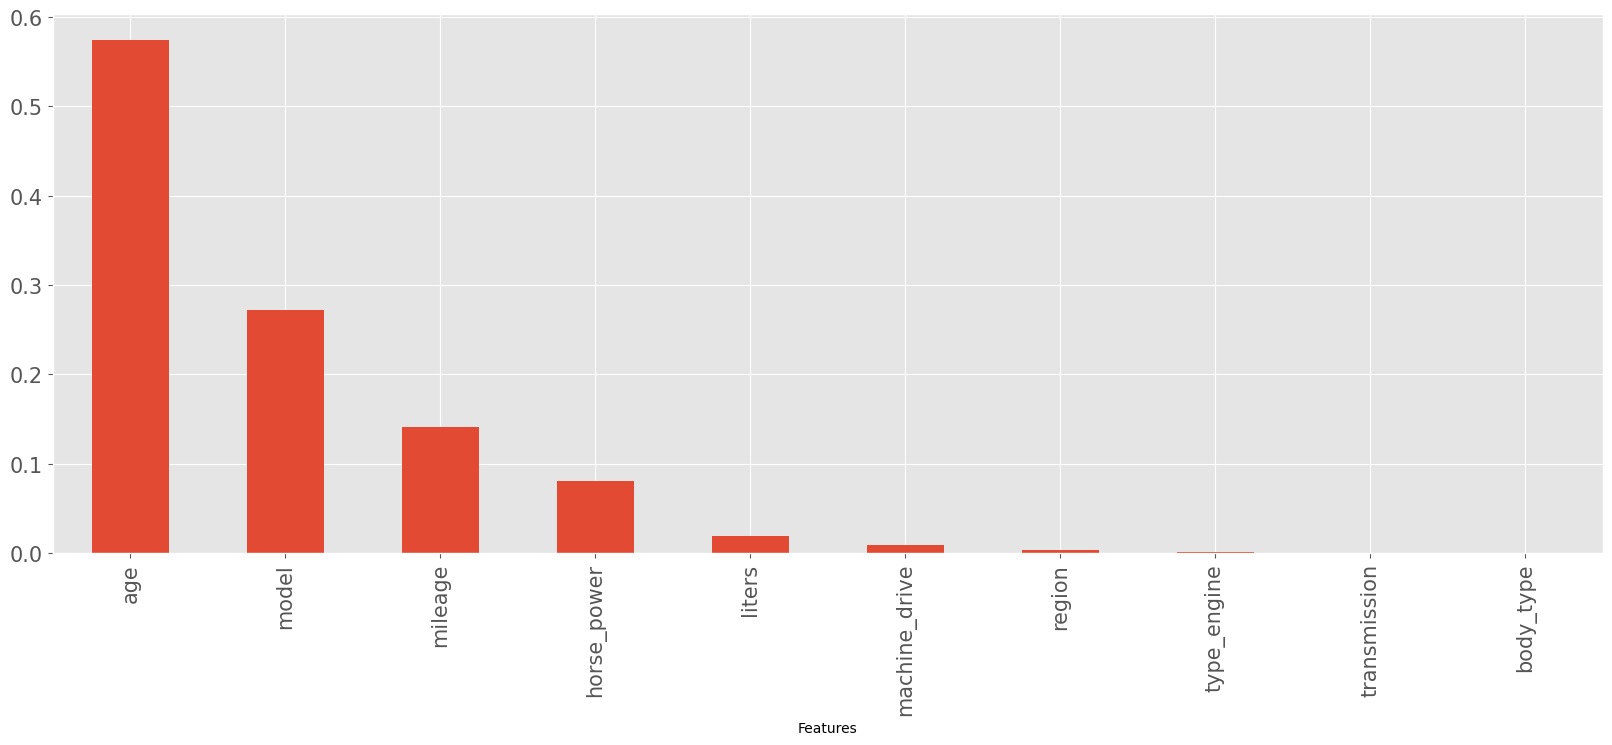

In [41]:
from sklearn.inspection import permutation_importance


r = permutation_importance(lgb_optuna, X_test, y_test, n_repeats=10)

perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()),
                       index=('Score', 'Features'))

perm_df = perm_df.T.sort_values(ascending=False, by='Score')
perm_df.set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

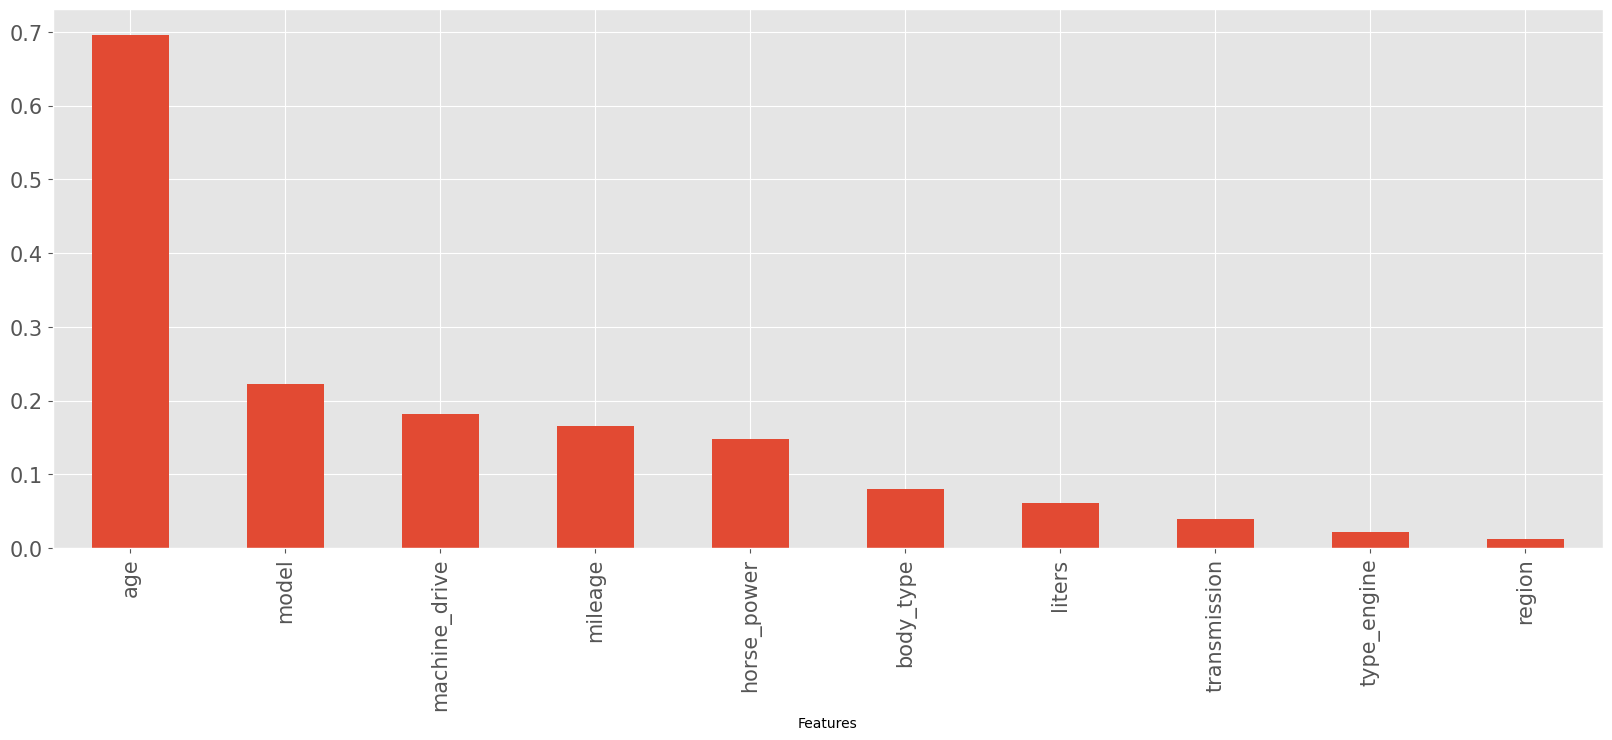

In [42]:
r = permutation_importance(cat_optuna, X_test, y_test, n_repeats=10)

perm_df = pd.DataFrame((r['importances_mean'], X_train.columns.to_list()),
                       index=('Score', 'Features'))

perm_df = perm_df.T.sort_values(ascending=False, by='Score')
perm_df.set_index('Features')['Score'].plot.bar(figsize=(20, 7), grid=True)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()